# Analyze STRF Parameters #
### Written by Kushal Bakshi for Dr. Mike Smotherman's Lab at Texas A&M University ###

## Objective: Visualize and quantify differences in parameters of different types of STRFs ##

> The notebook imports parameters of spectrotemporal receptive fields obtained from microelectrode array recordings from the primary auditory cortex (A1) of Mexican Free-Tailed Bats. Data indicates 4 categories of STRF are presented in the bat A1. The goal of this notebook is to quantify differences among STRFs and analyze each of the 4 categories in more detail.  

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, kruskal, ranksums, spearmanr
import scikit_posthocs as sp
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Declares the function to load the data but does not actually load the data until the following cell

+ Please update the path in variable `tcq10` and `bwAndIt` to your local absolute path where those files are stored.

In [2]:
def load_strf_summary(strfFilepath, peakFilepath):
    """Function loads features extracted from STRF for visualizations and statistical analyses.
    
    Args: 
        strfFilepath (string): A string to the absolute path to the MATLAB file with name `sorted_STRFs_032522`.
        peakFilepath (string): A string to the absolute path to the Excel file with name `STRF Summary.xlsx`.
    
    Returns:
        paramDF (pandas.DataFrame): A dataframe with all the parameters set up for visualization and stats.
    """
    summary = loadmat(strfFilepath, squeeze_me = True)
    paramDF = pd.DataFrame(summary['strf_table'], columns = summary['strf_table'][0])
    tcq10 = loadmat('C:/Users/kbakshi/Documents/Data/STRF Analysis/Peaks/Q10.mat', squeeze_me = True)
    bwAndIt = loadmat('C:/Users/kbakshi/Documents/Data/STRF Analysis/Peaks/BW and IT.mat', squeeze_me = True)
    paramDF = paramDF.drop(index = 0).reset_index()
    paramDF.drop(labels = 'index', axis = 1, inplace = True)
    paramDF['FrequencyBW'] = bwAndIt['peaks_width_table'][1:, 0]
    paramDF['IntegrationTime'] = bwAndIt['peaks_width_table'][1:, 1]
    paramDF['Q10'] = tcq10['q10']
    paramDF['TuningCF'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='D')
    paramDF['Peaks'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='E')
    paramDF['Type'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='F')
    return paramDF

### Please update the path in the cell below for `strfFilepath` and `peakFilepath` to your local absolute path where those files are stored

+ As a reminder, `strfFilepath` is the path to the MATLAB file containing features and `peakFilepath` is the Excel file with information about peak frequencies

In [3]:
strf_summary = load_strf_summary(strfFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/sorted_STRFs_032522.mat', peakFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/STRF Summary.xlsx')
col_list = list(strf_summary.columns)
for column in range(2, len(col_list)-2):
    strf_summary[col_list[column]] = strf_summary[col_list[column]].astype('float64')

### The next few cells clean up and declare some variables that will be used later

In [4]:
strf_summary.drop(strf_summary[strf_summary.Seperability < 0].index, inplace=True)

In [5]:
color_list = ["red", "blue", "green", "purple"]

In [6]:
params = {'xtick.labelsize': 28, 'ytick.labelsize': 28, 'axes.labelsize': 28, 'figure.titlesize': 20,
              'figure.titleweight': 'bold', 'font.family': 'Segoe UI', 'lines.linewidth': 3}
plt.rcParams.update(params)

In [7]:
colors = {'Broad': 'red', 'Multi': 'blue', 'Single': 'green', 'Stack': 'purple'}

In [8]:
# Check for NaN values
strf_summary.columns[strf_summary.isna().any()].tolist()

['PeakInhibitoryFrequency',
 'LatencyAtMin',
 'InhibitoryIntegrationTime',
 'InhibitoryOctaveBW',
 'InhibitoryFreqBW']

## Counts and plots of each type and number of peaks ##

In [9]:
print('Total Single dFM = ' + str(np.sum(strf_summary['Type'] == 'Single')))
print('Total Broad = ' + str(np.sum(strf_summary['Type'] == 'Broad')))
print('Total Multipeak = ' + str(np.sum(strf_summary['Type'] == 'Multi')))
print('Total Stacked Peak = ' + str(np.sum(strf_summary['Type'] == 'Stack')))

Total Single dFM = 40
Total Broad = 28
Total Multipeak = 51
Total Stacked Peak = 11


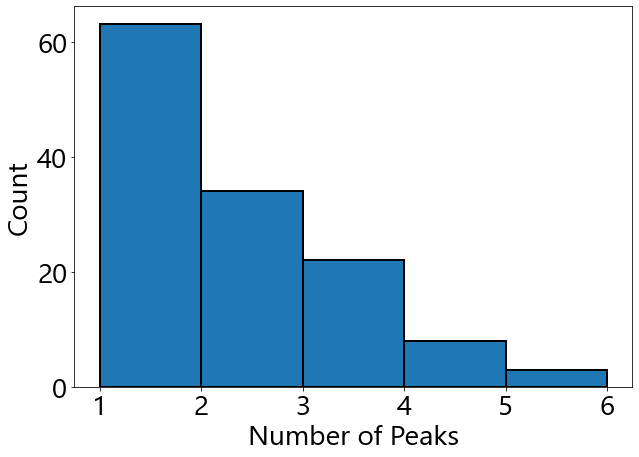

In [10]:
_, ax = plt.subplots(figsize = (10,7))
strf_summary.hist(column = 'Peaks', ax=ax, bins = range(1, 6+1, 1), backend = 'matplotlib', edgecolor = 'black', linewidth=2)
ax.grid(False)
plt.suptitle('')
ax.set_title('')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Peaks');

## Tuning Curve CF vs STRF Peak Excitatory Frequency. Plot + spearmanr

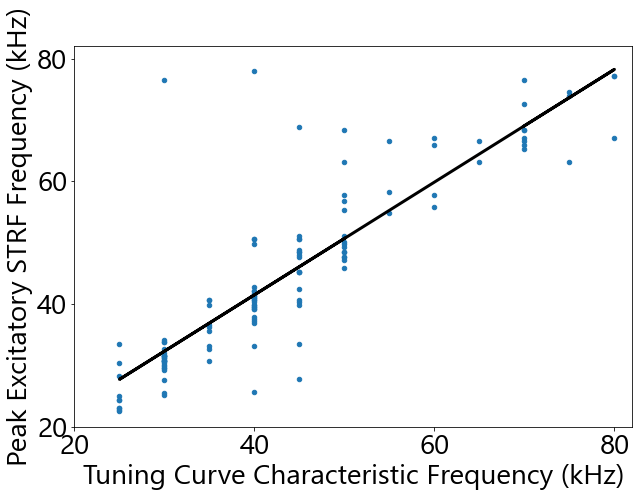

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
strf_summary.plot.scatter(x='TuningCF', y='PeakExcitatoryFrequency', ax=ax, backend='matplotlib')
ax.set_xlabel('Tuning Curve Characteristic Frequency (kHz)')
ax.set_xlim(20, 82)
ax.set_ylabel('Peak Excitatory STRF Frequency (kHz)')
ax.set_ylim(20, 82)
b, m = np.polynomial.polynomial.polyfit(strf_summary.TuningCF, strf_summary.PeakExcitatoryFrequency, 1)
ax.plot(strf_summary.TuningCF, b + m*strf_summary.TuningCF, 'k-')
#plt.savefig('U:\Figures\Thesis\TuningCF v STRF CF.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [12]:
spearmanr(strf_summary.TuningCF, strf_summary.PeakExcitatoryFrequency)

SpearmanrResult(correlation=0.8788605345874541, pvalue=5.782564608984679e-43)

# Principal Components Analysis #

In [13]:
def dimensionReduction(X, scaling=None):
    if scaling is None:
        pca = PCA().fit(np.nan_to_num(X, nan=0))
        pca_tran = pca.fit_transform(np.nan_to_num(X, nan=0))
    elif scaling == 'standard':
        pca = PCA().fit(np.nan_to_num(StandardScaler().fit_transform(X), nan=0))
        pca_tran = pca.fit_transform(np.nan_to_num(StandardScaler().fit_transform(X), nan=0))
    elif scaling == 'minmax':
        pca = PCA().fit(np.nan_to_num(MinMaxScaler().fit_transform(X), nan=0))
        pca_tran = pca.fit_transform(np.nan_to_num(MinMaxScaler().fit_transform(X), nan=0))
    else:
        raise Exception("Value for scaling not accepted. Must be 'None', 'standard', or 'minmax'.")
    return pca, pca_tran

In [14]:
pca_df = strf_summary.dropna(axis=1, how='any')

In [15]:
pca_cols = list(pca_df.columns)

In [16]:
strf_pca = dimensionReduction(pca_df[pca_cols[2:-2]], scaling='standard')

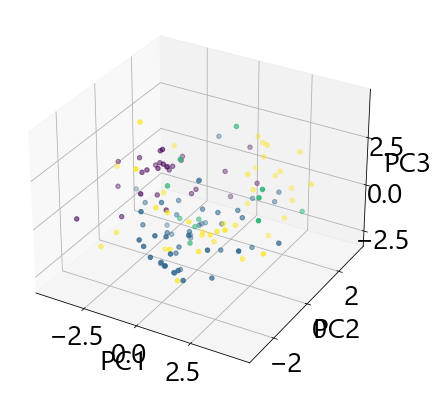

In [17]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strf_pca[1][:,0], strf_pca[1][:,1], strf_pca[1][:,2], c=pd.factorize(strf_summary['Type'])[0])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

Text(0, 0.5, 'PC2')

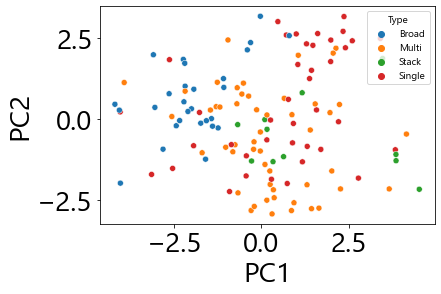

In [18]:
sns.scatterplot(x=strf_pca[1][:,0], y=strf_pca[1][:,1], hue=strf_summary['Type'])
plt.xlabel('PC1')
plt.ylabel('PC2')

Scree Plot Here:

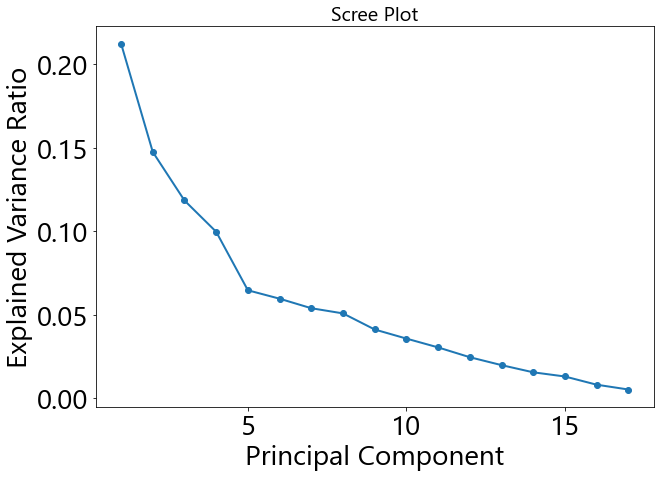

In [19]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(strf_pca[0].n_components_)+1, strf_pca[0].explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot', fontsize=20)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

# Statistical tests and corresponding plots for all features

## Analysis of STRF Latency

In [20]:
# Remove latency outliers - outlier if outside physiologically-relevant range
strf_summary.loc[np.array(np.where(strf_summary['LatencyAtMin'] >= 80)).flatten(), 'LatencyAtMin'] = np.nan

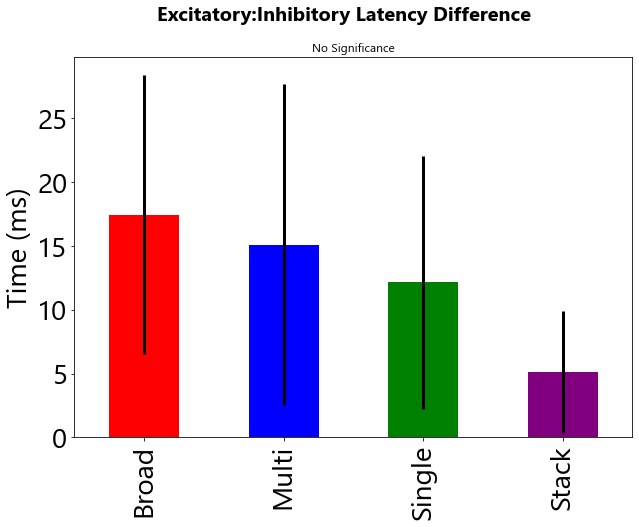

In [21]:
latency_diff = np.abs(strf_summary['LatencyAtMin'] - strf_summary['LatencyAtPeak'])
fig, ax = plt.subplots(figsize=(10,7))
latency_diff.groupby(strf_summary['Type']).agg(np.mean).plot(kind='bar', ax=ax, yerr=latency_diff.groupby(strf_summary['Type']).agg(np.std),\
                                                            backend='matplotlib', color=color_list)
plt.ylabel('Time (ms)')
plt.xlabel('')
plt.suptitle('Excitatory:Inhibitory Latency Difference')
plt.title('No Significance');

In [22]:
f_val, p_val = kruskal(latency_diff[np.array(np.where(strf_summary['Type'] == 'Broad')).flatten()],\
                       latency_diff[np.array(np.where(strf_summary['Type'] == 'Multi')).flatten()],\
                       latency_diff[np.array(np.where(strf_summary['Type'] == 'Broad')).flatten()],\
                       latency_diff[np.array(np.where(strf_summary['Type'] == 'Broad')).flatten()], nan_policy='omit')
print('P-value = ', str(p_val))

P-value =  0.2581230115573879


In [23]:
parameter = 'LatencyAtPeak'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.00205737849836989


In [24]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.060760,0.004282,0.012026
Multi,0.060760,1.000000,0.375968,0.329369
Single,0.004282,0.375968,1.000000,0.470513
Stack,0.012026,0.329369,0.470513,1.000000


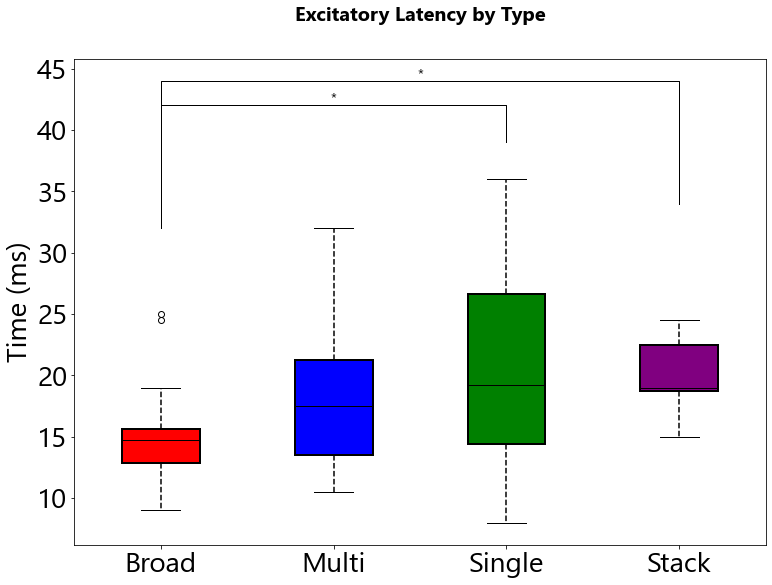

In [25]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(12,9), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Time (ms)')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('Excitatory Latency by Type');

# Annotations for the statistical analysis
x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max() + 3, 3, 'k'
plt.plot([x0, x0, x2, x2], [y1-7, y1+h1, y1+h1, y1], lw=1, c=color)
plt.text((x0+x2)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = y1 + 2, 3
plt.plot([x0, x0, x3, x3], [y2-5, y2+h2, y2+h2, y2-7], lw=1, c=color)
plt.text((x0+x3)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14);
#plt.savefig('U:\Figures\Thesis\Excitatory Latency by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

# Analysis of Modulation Transfer Functions #

## Spectral Modulations ##

In [26]:
parameter = 'sMTF'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  3.3566614257857574e-06


In [27]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.070136,0.000130,0.000069
Multi,0.070136,1.000000,0.030316,0.005332
Single,0.000130,0.030316,1.000000,0.123761
Stack,0.000069,0.005332,0.123761,1.000000


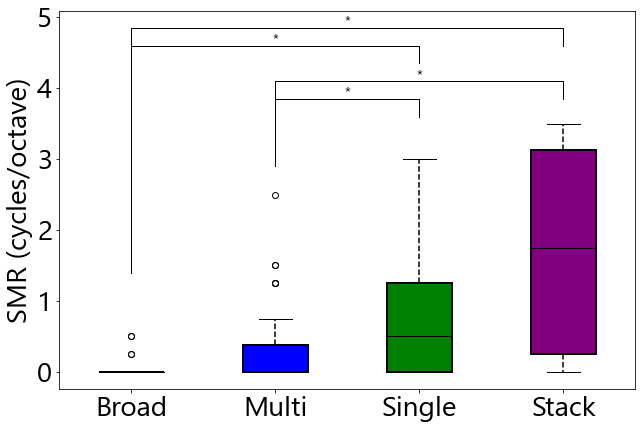

In [28]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('SMR (cycles/octave)')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('');

# Annotations for stats
x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max() + 0.1, 0.25, 'k'
plt.plot([x1, x1, x2, x2], [y1-0.7, y1+h1, y1+h1, y1], lw=1, c=color)
plt.text((x1+x2)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = y1 + 0.25, 0.25
plt.plot([x1, x1, x3, x3], [y2, y2+h2, y2+h2, y2], lw=1, c=color)
plt.text((x1+x3)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14)

y3, h3 = y2 + 0.5, 0.25
plt.plot([x0, x0, x2, x2], [y3-2, y3+h3, y3+h3, y3], lw=1, c=color)
plt.text((x0+x2)*0.5, y3+h3, '*', ha='center', va='bottom', color=color, fontsize=14)

y4, h4 = y3 + 0.25, 0.25
plt.plot([x0, x0, x3, x3], [y4-3.2, y4+h4, y4+h4, y4], lw=1, c=color)
plt.text((x0+x3)*0.5, y4+h4, '*', ha='center', va='bottom', color=color, fontsize=14);
#plt.savefig('U:\Figures\Thesis\sMTF by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

## Temporal Modulations ##

In [29]:
parameter = 'tMTF'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.010971968591400927


In [30]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.066443,0.663698,0.074074
Multi,0.066443,1.000000,0.119928,0.663698
Single,0.663698,0.119928,1.000000,0.119928
Stack,0.074074,0.663698,0.119928,1.000000


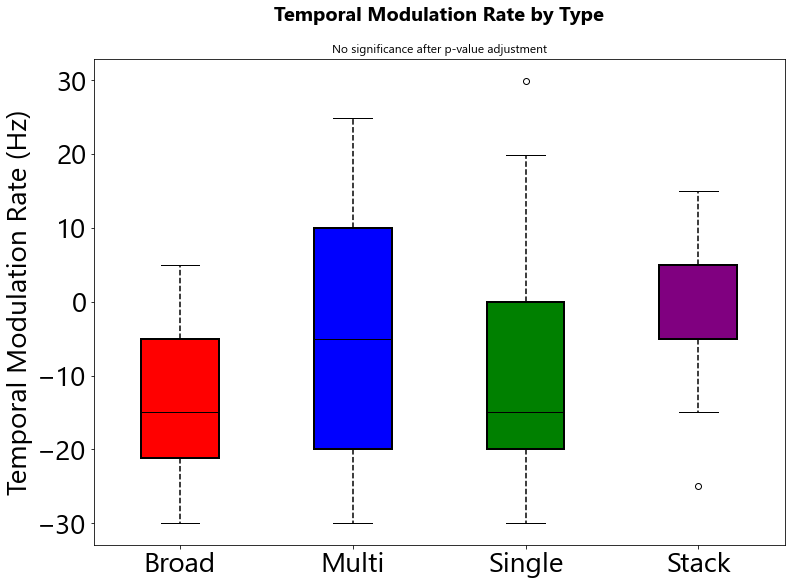

In [31]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(12,9), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Temporal Modulation Rate (Hz)')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('No significance after p-value adjustment')
plt.suptitle('Temporal Modulation Rate by Type');
#plt.savefig('U:/Figures/Thesis/tMTF by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

## TMR:SMR Ratio (FM Velocity Preferences) ##

In [32]:
velocity = np.divide(abs(strf_summary.tMTF), strf_summary.sMTF)
velocity[velocity == np.inf] = np.nan

Text(0.5, 0.98, 'Preferred Stimulus Velocity')

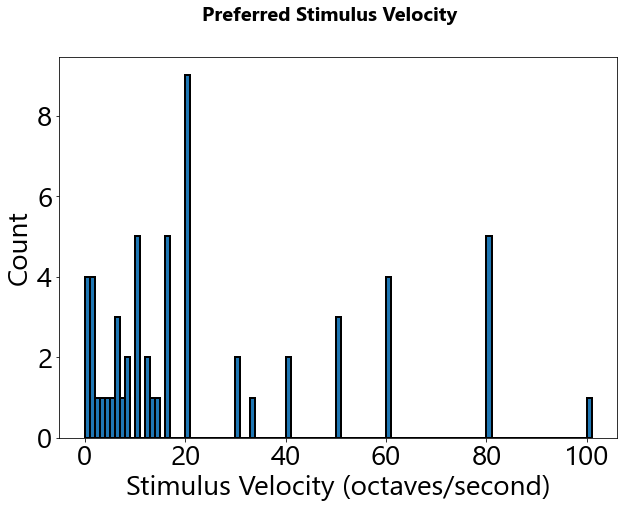

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(velocity, bins=np.arange(np.min(velocity), np.max(velocity)+1, 1), edgecolor='k', linewidth=2)
ax.set_ylabel('Count')
ax.set_xlabel('Stimulus Velocity (octaves/second)')
plt.suptitle('Preferred Stimulus Velocity')
#plt.savefig('U:/Figures/Thesis/Stimulus Velocity.png', dpi=300, bbox_inches='tight', facecolor='w')

Text(0, 0.5, 'sMTF (cycles/octave)')

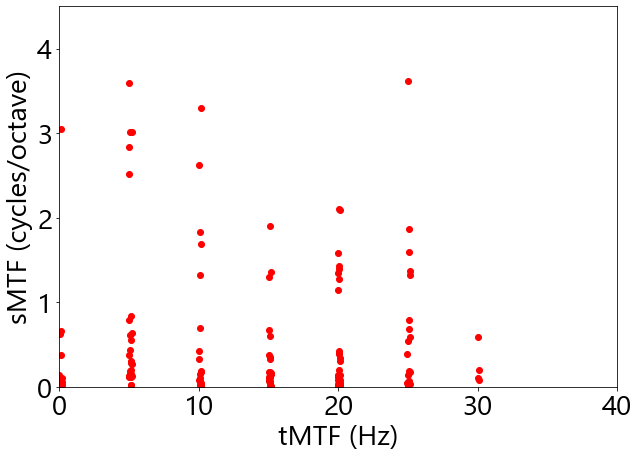

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(x=np.abs(strf_summary['tMTF']), y=strf_summary['sMTF'], color='red')
dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(0, 0.2, offsets.shape)
dots.set_offsets(jittered_offsets)
ax.set_xlim(0, 40)
ax.set_ylim(0, 4.5)
ax.set_xlabel('tMTF (Hz)')
ax.set_ylabel('sMTF (cycles/octave)')
#plt.savefig('U:/Figures/Thesis/tmf v smf.png', dpi=300, bbox_inches='tight', facecolor='w')

# Frequency BW and Integration Times #

In [35]:
parameter = 'FrequencyBW'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  1.1571165037992247e-13


In [36]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000e+00,5.047296e-12,2.803871e-07,3.641152e-09
Multi,5.047296e-12,1.000000e+00,1.779960e-01,1.779960e-01
Single,2.803871e-07,1.779960e-01,1.000000e+00,3.320848e-02
Stack,3.641152e-09,1.779960e-01,3.320848e-02,1.000000e+00


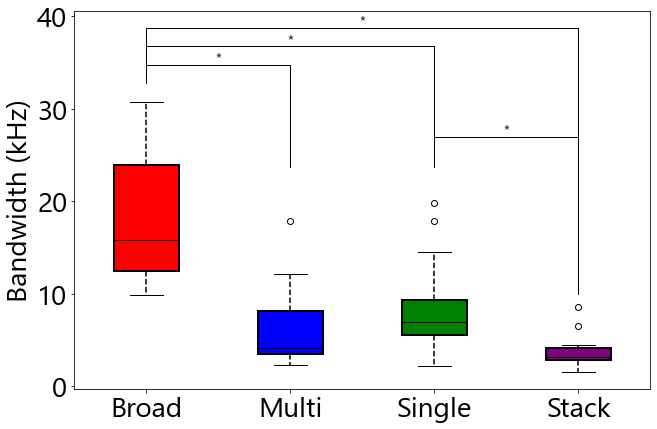

In [37]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Bandwidth (kHz)')
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels([0, 10, 20, 30, 40])
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('');


x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max() + 2000, 2000, 'k'
plt.plot([x0, x0, x1, x1], [y1, y1+h1, y1+h1, y1-9000], lw=1, c=color)
plt.text((x0+x1)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = y1 + 2000, 2000
plt.plot([x0, x0, x2, x2], [y2, y2+h2, y2+h2, y2-11000], lw=1, c=color)
plt.text((x0+x2)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14);

y3, h3 = y2 + 2000, 2000
plt.plot([x0, x0, x3, x3], [y3, y3+h3, y3+h3, y3-25000], lw=1, c=color)
plt.text((x0+x3)*0.5, y3+h3, '*', ha='center', va='bottom', color=color, fontsize=14);

y4, h4 = 25000, 2000
plt.plot([x2, x2, x3, x3], [y4, y4+h4, y4+h4, y4-15000], lw=1, c=color)
plt.text((x2+x3)*0.5, y4+h4, '*', ha='center', va='bottom', color=color, fontsize=14);
#plt.savefig('U:/Figures/Thesis/BW by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

In [38]:
parameter = 'IntegrationTime'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.019761371871231347


In [39]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.194291,0.828353,0.438534
Multi,0.194291,1.000000,0.194291,0.045145
Single,0.828353,0.194291,1.000000,0.437705
Stack,0.438534,0.045145,0.437705,1.000000


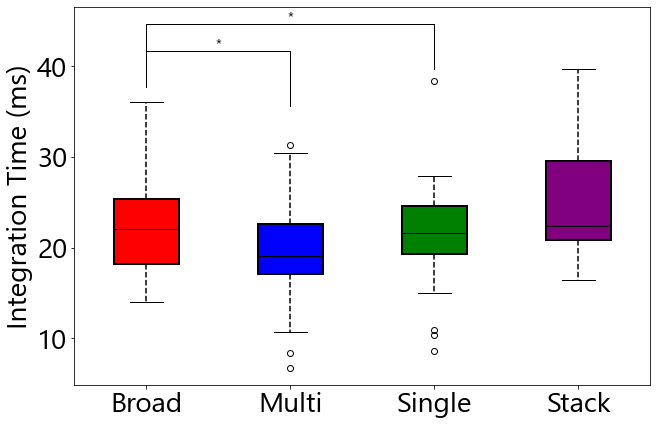

In [40]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Integration Time (ms)')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('');

# Annotations for stats

x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max(), 5, 'k'
plt.plot([x0, x0, x2, x2], [y1, y1+h1, y1+h1, y1], lw=1, c=color)
plt.text((x0+x2)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = y1 - 3, 5
plt.plot([x0, x0, x1, x1], [y2+1, y2+h2, y2+h2, y2-1], lw=1, c=color)
plt.text((x0+x1)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14);
#plt.savefig('U:/Figures/Thesis/Integration Time by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

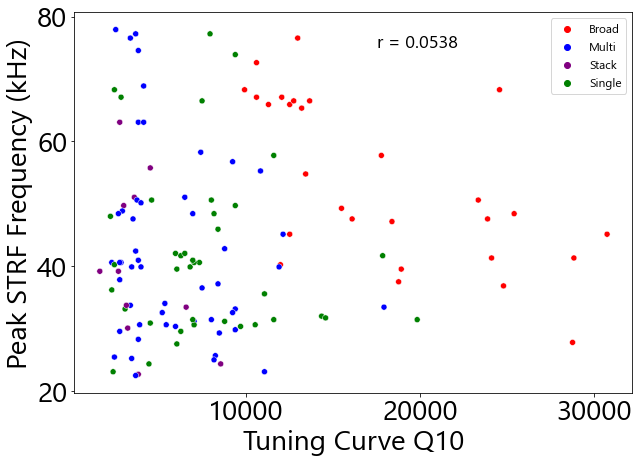

In [41]:
colors = {'Broad': 'red', 'Multi': 'blue', 'Single': 'green', 'Stack': 'purple'}
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='FrequencyBW', y='PeakExcitatoryFrequency', hue='Type', data=strf_summary, palette=colors)
plt.text(17500, 75, str('r = ' + str(float("{0:.4f}".format(strf_summary['FrequencyBW'].corr(strf_summary['PeakExcitatoryFrequency']))))), fontsize=18)
ax.set_ylabel('Peak STRF Frequency (kHz)')
ax.set_xlabel('Tuning Curve Q10')
ax.legend(loc='upper right', fontsize=12)
plt.show()

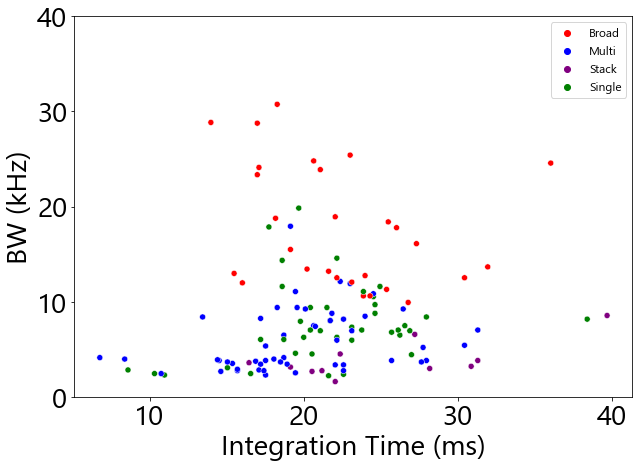

In [42]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='IntegrationTime', y='FrequencyBW', hue='Type', data=strf_summary, palette=colors)
ax.set_ylabel('BW (kHz)')
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels([0, 10, 20, 30, 40])
ax.set_xlabel('Integration Time (ms)')
ax.legend(loc='upper right', fontsize=12)
#plt.savefig('U:/Figures/Thesis/IntegrationTime v BW.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [43]:
spearmanr(strf_summary.IntegrationTime, strf_summary.FrequencyBW)

SpearmanrResult(correlation=0.23000348271772986, pvalue=0.008475728762346927)

## Q10 by Type ##

In [44]:
parameter = 'Q10'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.09298891059767458


In [45]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.320343,0.454353,0.097885
Multi,0.320343,1.000000,0.664744,0.454353
Single,0.454353,0.664744,1.000000,0.416529
Stack,0.097885,0.454353,0.416529,1.000000


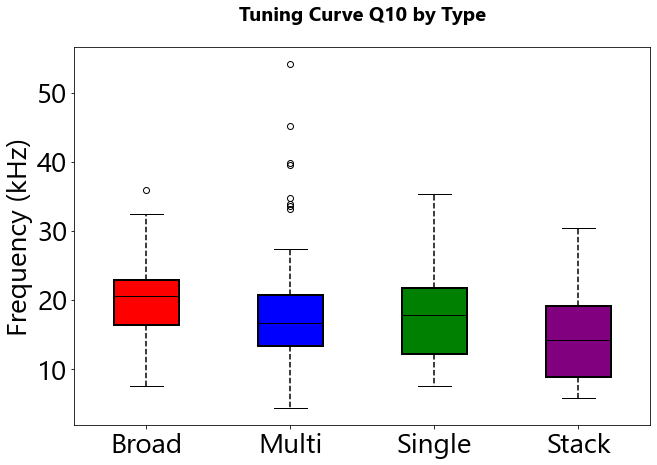

In [46]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Frequency (kHz)')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('Tuning Curve Q10 by Type');

## Q10 vs CF ##

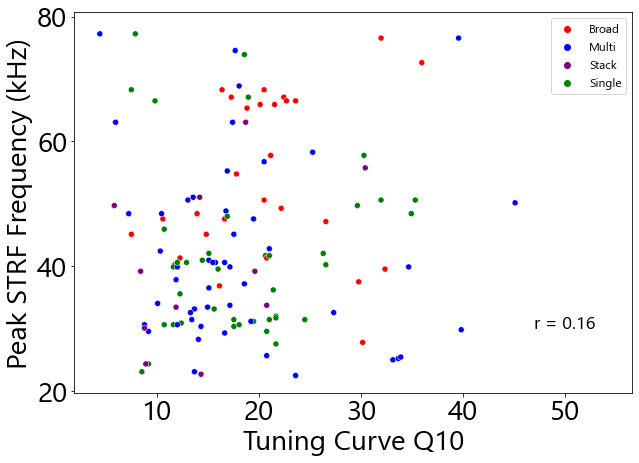

In [47]:
colors = {'Broad': 'red', 'Multi': 'blue', 'Single': 'green', 'Stack': 'purple'}
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Q10', y='PeakExcitatoryFrequency', hue='Type', data=strf_summary, palette=colors)
plt.text(47, 30, str('r = ' + str(float("{0:.4f}".format(strf_summary['Q10'].corr(strf_summary['PeakExcitatoryFrequency']))))), fontsize=18)
ax.set_ylabel('Peak STRF Frequency (kHz)')
ax.set_xlabel('Tuning Curve Q10')
ax.legend(loc='upper right', fontsize=12)
plt.show()
#plt.savefig('U:/Figures/Thesis/Q10 vs Peak Frequency.png', dpi=300, bbox_inches='tight', facecolor='w')

## Integration time vs Latency ##

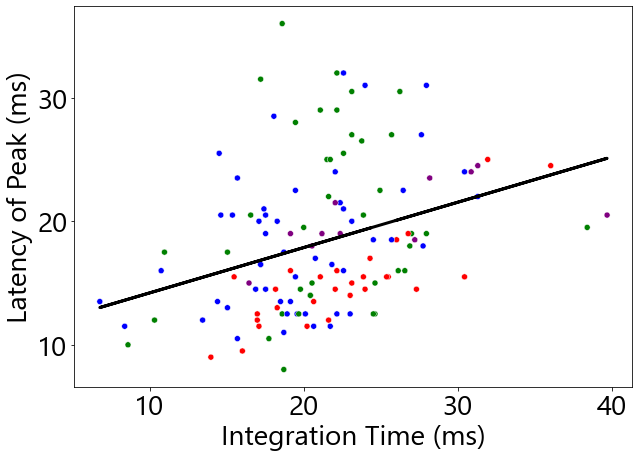

In [48]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='IntegrationTime', y='LatencyAtPeak', hue='Type', data=strf_summary, palette=colors)
ax.set_ylabel('Latency of Peak (ms)')
ax.set_xlabel('Integration Time (ms)')
b, m = np.polynomial.polynomial.polyfit(strf_summary.IntegrationTime, strf_summary.LatencyAtPeak, 1)
ax.plot(strf_summary.IntegrationTime, b + m*strf_summary.IntegrationTime, 'k-')
#plt.legend(fontsize=12)
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/Integration Time vs Latency.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [49]:
spearmanr(strf_summary.IntegrationTime, strf_summary.LatencyAtPeak)

SpearmanrResult(correlation=0.38814372521376944, pvalue=5.043213616669957e-06)

# Direction Selectivity #

In [50]:
parameter = 'DSI'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.00313388142673324


In [51]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.062816,0.882241,0.075373
Multi,0.062816,1.000000,0.019397,0.779733
Single,0.882241,0.019397,1.000000,0.062816
Stack,0.075373,0.779733,0.062816,1.000000


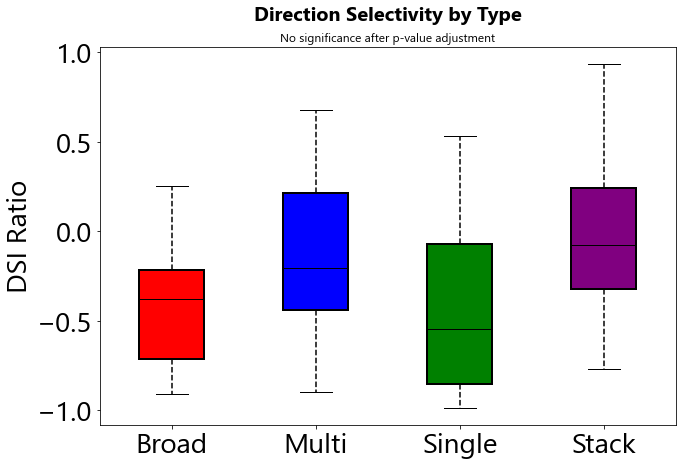

In [52]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('DSI Ratio')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('No significance after p-value adjustment')
plt.suptitle('Direction Selectivity by Type');

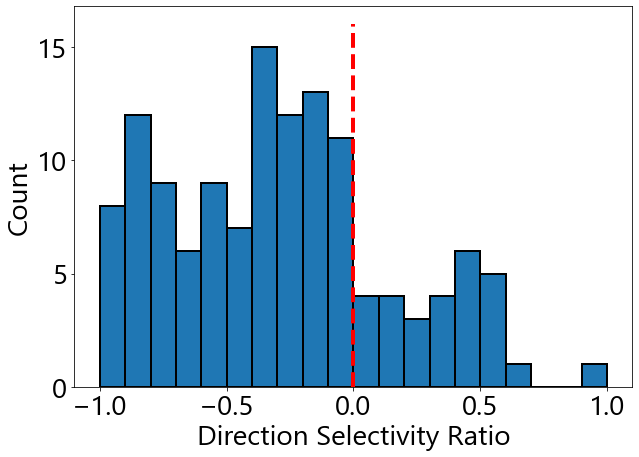

In [53]:
ax = strf_summary.DSI.plot.hist(backend='matplotlib', figsize=(10,7), edgecolor='k', linewidth=2, bins=np.arange(-1, 1+0.1, 0.1))
ax.vlines(x=0, ymin=0, ymax=16, linestyle='dashed', linewidth=4, color='r')
ax.set_ylabel('Count')
ax.set_xlabel('Direction Selectivity Ratio')
plt.suptitle('');
#plt.savefig('U:/Figures/Thesis/DSI.png', dpi=300, bbox_inches='tight', facecolor='w')

# STRF Seperability #

In [54]:
parameter = 'Seperability'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  6.774314671445946e-06


In [55]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.000261,0.099752,0.263154
Multi,0.000261,1.000000,0.067263,0.000261
Single,0.099752,0.067263,1.000000,0.038851
Stack,0.263154,0.000261,0.038851,1.000000


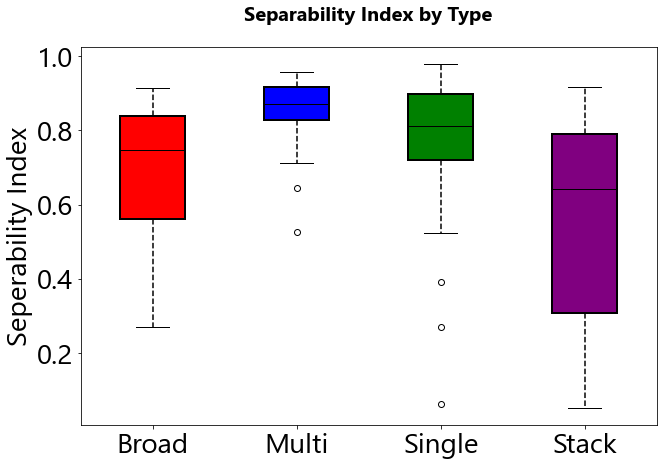

In [56]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
ax.set_ylabel('Seperability Index')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.title('')
plt.suptitle('Separability Index by Type');

Text(0, 0.5, 'Count')

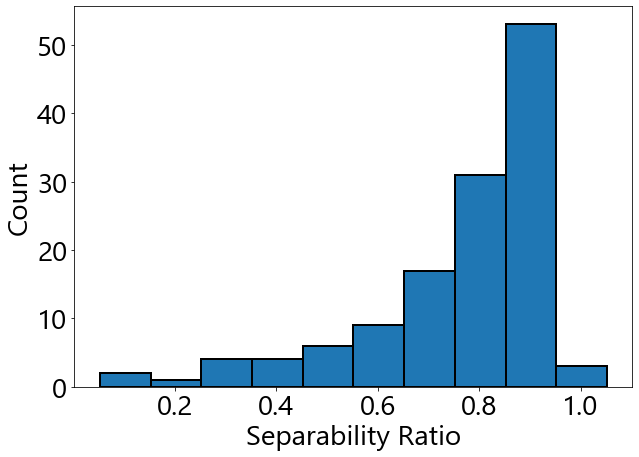

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(strf_summary[parameter], bins=np.arange(np.min(strf_summary[parameter]), np.max(strf_summary[parameter])+0.1, 0.1), edgecolor='k', linewidth=2)
ax.set_xlabel('Separability Ratio')
ax.set_ylabel('Count')
#plt.savefig('U:/Figures/Thesis/separability.png', dpi=300, bbox_inches='tight', facecolor='w')

In [58]:
strf_summary.groupby('Type')['Seperability'].mean()

Type
Broad     0.702821
Multi     0.854841
Single    0.770016
Stack     0.540009
Name: Seperability, dtype: float64

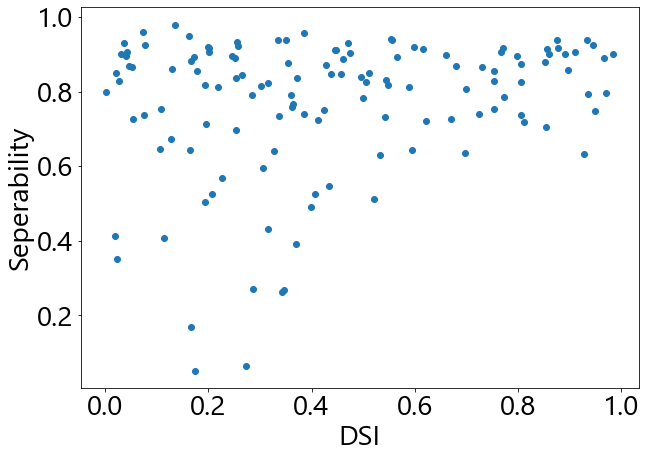

In [59]:
_, ax = plt.subplots(figsize=(10, 7))
plt.scatter(np.abs(strf_summary['DSI']), strf_summary['Seperability'])
ax.set_ylabel('Seperability')
ax.set_xlabel('DSI')
#plt.savefig('U:/Figures/Thesis/CF v RC.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

# Anatomical Location #
## *parameter* vs RCLocation or Depth ##

In [60]:
parameter = 'Depth'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.0007801632209003211


In [61]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.002039,0.031751,0.004470
Multi,0.002039,1.000000,0.520479,0.520479
Single,0.031751,0.520479,1.000000,0.319437
Stack,0.004470,0.520479,0.319437,1.000000


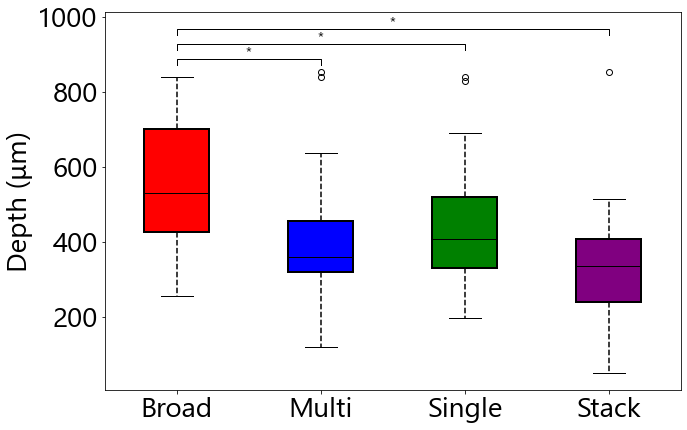

In [62]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.suptitle('');
plt.title('')
plt.ylabel('Depth (μm)');


# Annotations for stats
x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary['Depth'].max() + 20, 15, 'k'
plt.plot([x0, x0, x1, x1], [y1, y1+h1, y1+h1, y1], lw=1, c=color)
plt.text((x0+x1)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = strf_summary['Depth'].max() + 60, 15
plt.plot([x0, x0, x2, x2], [y2, y2+h2, y2+h2, y2], lw=1, c=color)
plt.text((x0+x2)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14)

y3, h3 = strf_summary['Depth'].max() + 100, 15
plt.plot([x0, x0, x3, x3], [y3, y3+h3, y3+h3, y3], lw=1, c=color)
plt.text((x0+x3)*0.5, y3+h3, '*', ha='center', va='bottom', color=color, fontsize=14);

#plt.savefig('U:\Figures\Thesis\Depth by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

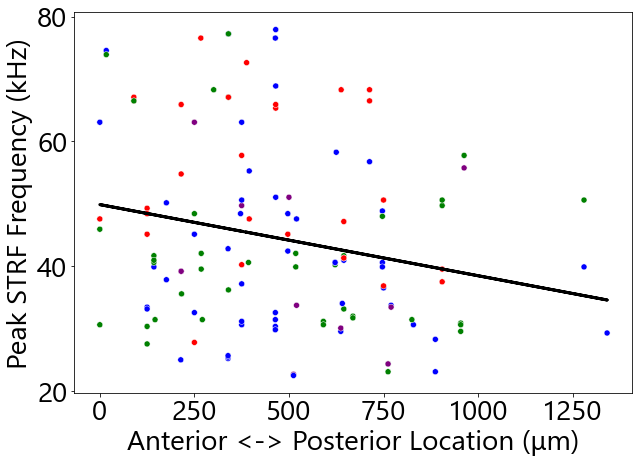

In [63]:
colors = {'Broad': 'red', 'Multi': 'blue', 'Single': 'green', 'Stack': 'purple'}
strf_summary['RCLocation'] = np.abs(strf_summary['RCLocation'])
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='RCLocation', y='PeakExcitatoryFrequency', hue='Type', data=strf_summary, palette=colors)
ax.set_ylabel('Peak STRF Frequency (kHz)')
ax.set_xlabel('Anterior <-> Posterior Location (μm)')
#ax.legend(loc='upper right', fontsize=14)
ax.get_legend().remove()
b, m = np.polynomial.polynomial.polyfit(strf_summary.RCLocation, strf_summary.PeakExcitatoryFrequency, 1)
ax.plot(strf_summary.RCLocation, b + m*strf_summary.RCLocation, 'k-')
#plt.savefig('U:/Figures/Thesis/CF v RC.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [64]:
spearmanr(strf_summary.RCLocation, strf_summary.PeakExcitatoryFrequency)

SpearmanrResult(correlation=-0.19697407537965134, pvalue=0.024690381639716628)

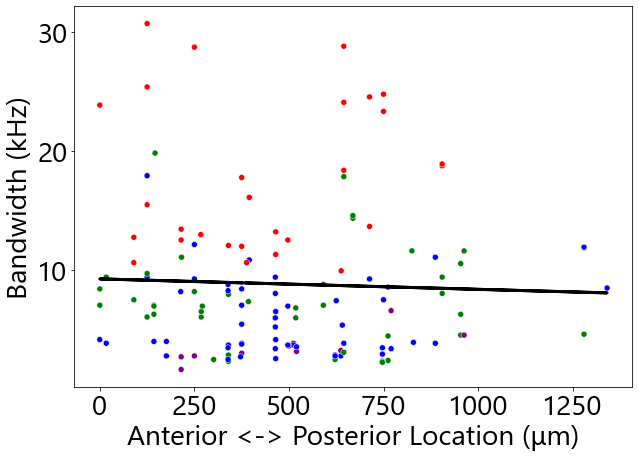

In [65]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='RCLocation', y='FrequencyBW', hue='Type', data=strf_summary, palette=colors)
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels([0, 10, 20, 30])
ax.set_ylabel('Bandwidth (kHz)')
ax.set_xlabel('Anterior <-> Posterior Location (μm)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.RCLocation, strf_summary.FrequencyBW, 1)
ax.plot(strf_summary.RCLocation, b + m*strf_summary.RCLocation, 'k-')
#plt.legend(fontsize=12)
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/FrequencyBW v RC.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [66]:
spearmanr(strf_summary.RCLocation, strf_summary.FrequencyBW)

SpearmanrResult(correlation=-0.04603058544032115, pvalue=0.60303827299436)

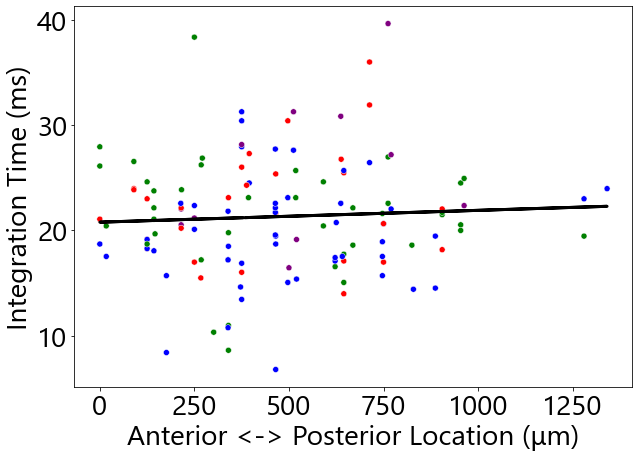

In [67]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='RCLocation', y='IntegrationTime', hue='Type', data=strf_summary, palette=colors)
ax.set_ylabel('Integration Time (ms)')
ax.set_xlabel('Anterior <-> Posterior Location (μm)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.RCLocation, strf_summary.IntegrationTime, 1)
ax.plot(strf_summary.RCLocation, b + m*strf_summary.RCLocation, 'k-')
#plt.legend(fontsize=12)
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/IntegrationTime v RC.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [68]:
spearmanr(strf_summary.RCLocation, strf_summary.IntegrationTime)

SpearmanrResult(correlation=0.03915793098115662, pvalue=0.658252783702645)

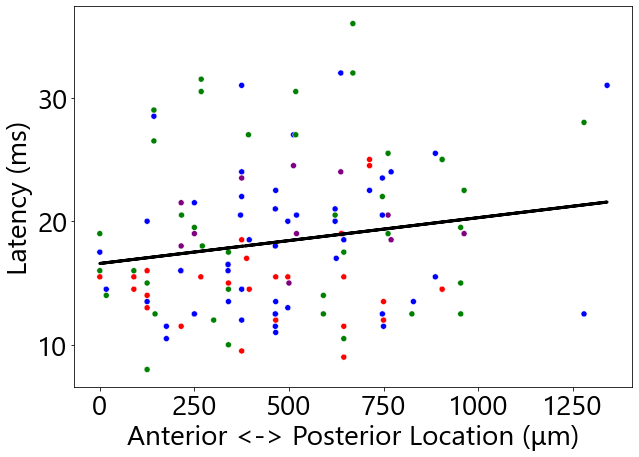

In [69]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='RCLocation', y='LatencyAtPeak', hue='Type', data=strf_summary, palette=colors)
ax.set_ylabel('Latency (ms)')
ax.set_xlabel('Anterior <-> Posterior Location (μm)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.RCLocation, strf_summary.LatencyAtPeak, 1)
ax.plot(strf_summary.RCLocation, b + m*strf_summary.RCLocation, 'k-')
#plt.legend(fontsize=12)
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/Latency v RC.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [70]:
spearmanr(strf_summary.RCLocation, strf_summary.LatencyAtPeak)

SpearmanrResult(correlation=0.1645301583234456, pvalue=0.061402873894294406)

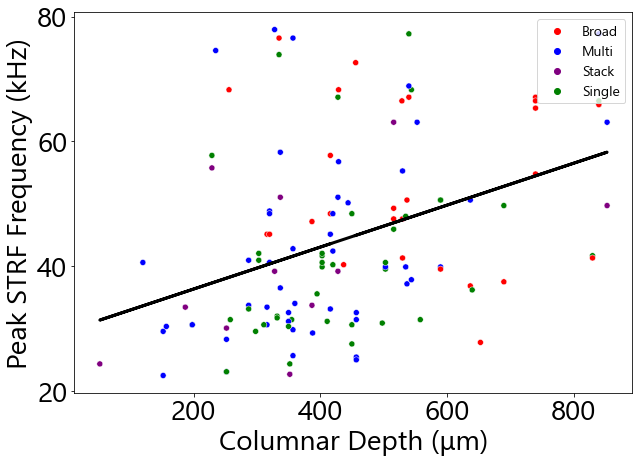

In [71]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Depth', y='PeakExcitatoryFrequency', hue='Type', data=strf_summary, palette=colors)
ax.set_xlabel('Columnar Depth (μm)')
ax.set_ylabel('Peak STRF Frequency (kHz)')
ax.legend(loc='upper right', fontsize=14)
b, m = np.polynomial.polynomial.polyfit(strf_summary.Depth, strf_summary.PeakExcitatoryFrequency, 1)
ax.plot(strf_summary.Depth, b + m*strf_summary.Depth, 'k-')
#ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/CF v Depth.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [72]:
spearmanr(strf_summary.Depth, strf_summary.PeakExcitatoryFrequency)

SpearmanrResult(correlation=0.3829279733351545, pvalue=6.908384773231391e-06)

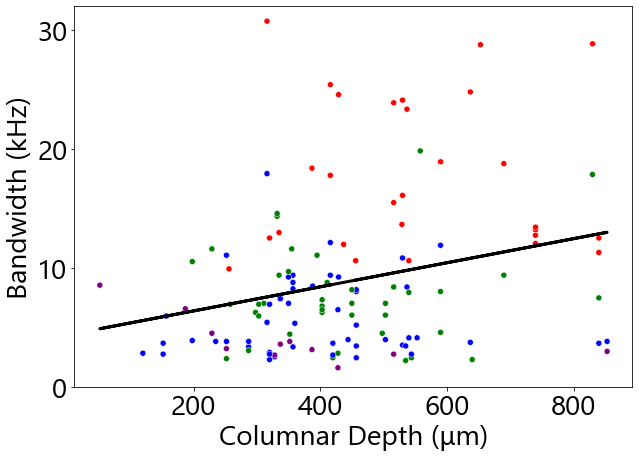

In [73]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Depth', y='FrequencyBW', hue='Type', data=strf_summary, palette=colors)
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels([0, 10, 20, 30])
ax.set_ylim(0, 32000)
ax.set_xlabel('Columnar Depth (μm)')
ax.set_ylabel('Bandwidth (kHz)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.Depth, strf_summary.FrequencyBW, 1)
ax.plot(strf_summary.Depth, b + m*strf_summary.Depth, 'k-')
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/FrequencyBW v Depth.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [74]:
spearmanr(strf_summary.Depth, strf_summary.FrequencyBW)

SpearmanrResult(correlation=0.22815573480823403, pvalue=0.009033593851911508)

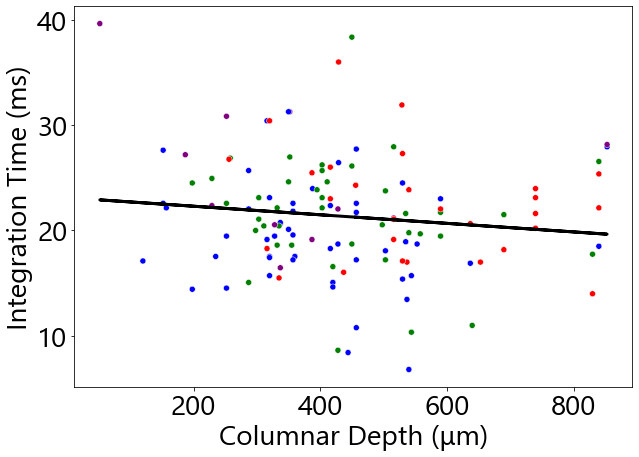

In [75]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Depth', y='IntegrationTime', hue='Type', data=strf_summary, palette=colors)
ax.set_xlabel('Columnar Depth (μm)')
ax.set_ylabel('Integration Time (ms)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.Depth, strf_summary.IntegrationTime, 1)
ax.plot(strf_summary.Depth, b + m*strf_summary.Depth, 'k-')
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/IntegrationTime v Depth.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [76]:
spearmanr(strf_summary.Depth, strf_summary.IntegrationTime)

SpearmanrResult(correlation=-0.12740376374809725, pvalue=0.14860117690549995)

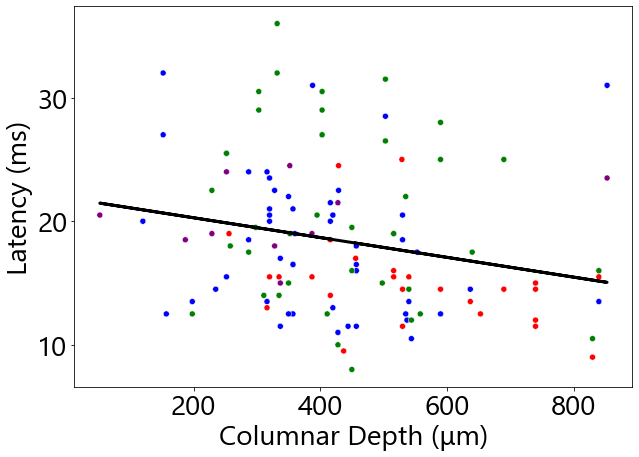

In [77]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Depth', y='LatencyAtPeak', hue='Type', data=strf_summary, palette=colors)
ax.set_xlabel('Columnar Depth (μm)')
ax.set_ylabel('Latency (ms)')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.Depth, strf_summary.LatencyAtPeak, 1)
ax.plot(strf_summary.Depth, b + m*strf_summary.Depth, 'k-')
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/Latency v Depth.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [78]:
spearmanr(strf_summary.Depth, strf_summary.LatencyAtPeak)

SpearmanrResult(correlation=-0.2890577470768704, pvalue=0.0008516715954273806)

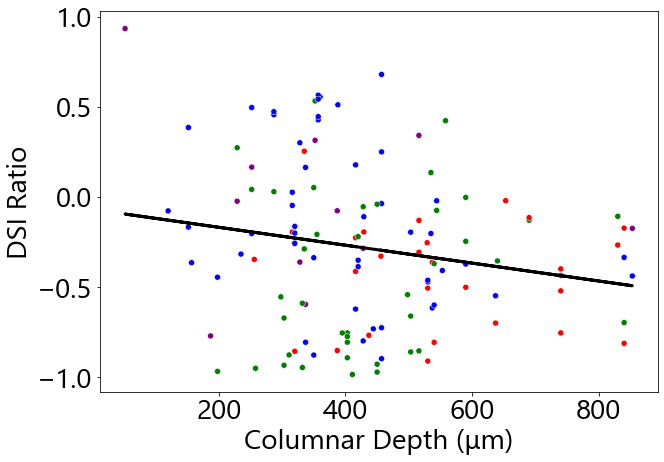

In [79]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='Depth', y='DSI', hue='Type', data=strf_summary, palette=colors)
ax.set_xlabel('Columnar Depth (μm)')
ax.set_ylabel('DSI Ratio')
#ax.legend(loc='upper right', fontsize=12)
b, m = np.polynomial.polynomial.polyfit(strf_summary.Depth, strf_summary.DSI, 1)
ax.plot(strf_summary.Depth, b + m*strf_summary.Depth, 'k-')
ax.get_legend().remove()
#plt.savefig('U:/Figures/Thesis/DSI v Depth.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [80]:
spearmanr(strf_summary.Depth, strf_summary.DSI)

SpearmanrResult(correlation=-0.15750157231432288, pvalue=0.073512215482507)

# Analysis of Peak Frequencies #

Text(0.5, 0.98, 'Excitatory Frequency Histograms')

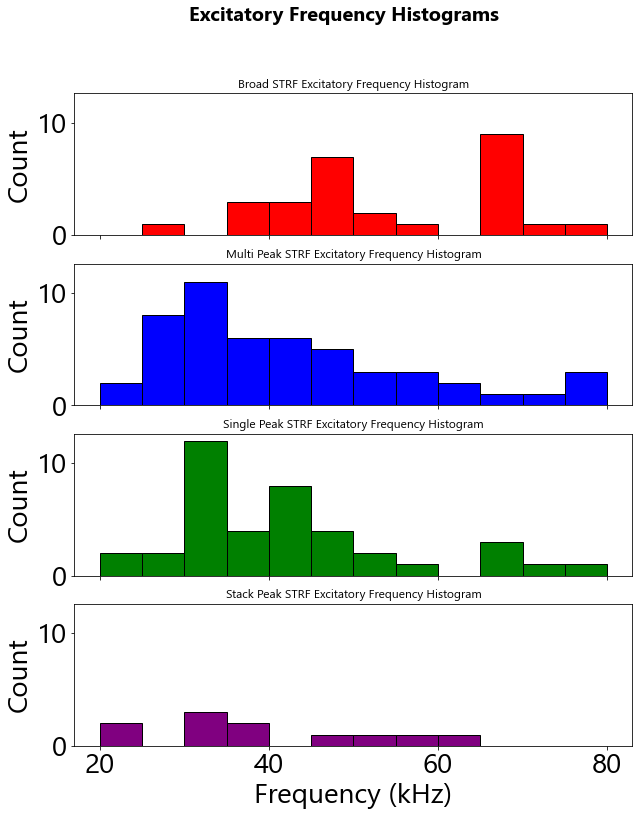

In [81]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True, sharey=True)
axs[0] = strf_summary.query('Type == "Broad"').PeakExcitatoryFrequency.plot(ax=axs[0], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[0])
axs[0].set_title('Broad STRF Excitatory Frequency Histogram')


axs[1] = strf_summary.query('Type == "Multi"').PeakExcitatoryFrequency.plot(ax=axs[1], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                           backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[1])
axs[1].set_title('Multi Peak STRF Excitatory Frequency Histogram')


axs[2] = strf_summary.query('Type == "Single"').PeakExcitatoryFrequency.plot(ax=axs[2], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                             backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[2])
axs[2].set_title('Single Peak STRF Excitatory Frequency Histogram')


axs[3] = strf_summary.query('Type == "Stack"').PeakExcitatoryFrequency.plot(ax=axs[3], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[3])
axs[3].set_title('Stack Peak STRF Excitatory Frequency Histogram')

for ax in axs.flat:
    ax.set(xlabel='Frequency (kHz)', ylabel='Count')
    ax.label_outer()
plt.suptitle('Excitatory Frequency Histograms')
#plt.savefig('U:/Figures/Thesis/Frequency Hist.png', dpi=300, bbox_inches='tight', facecolor='w')

Text(0.5, 0.98, 'Inhibitory Frequency Histograms')

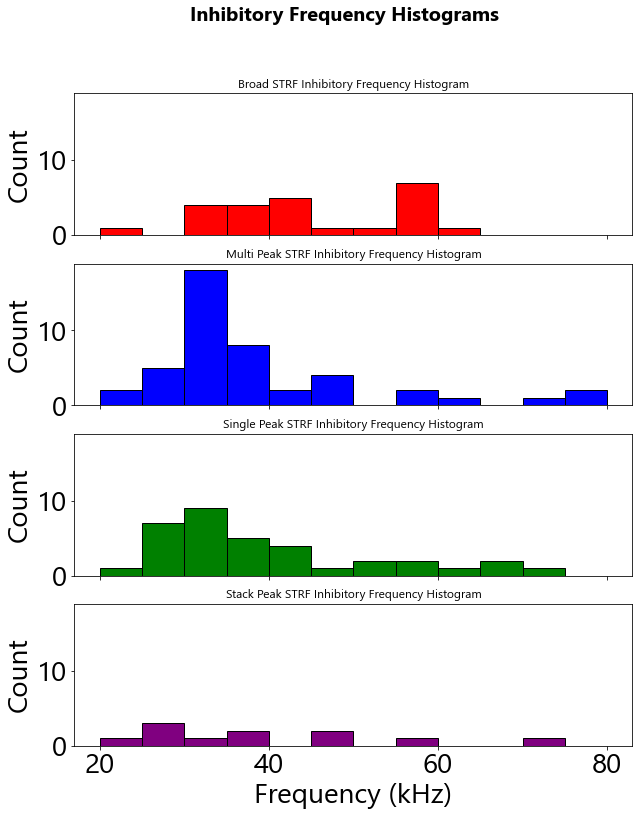

In [82]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True, sharey=True)
axs[0] = strf_summary.query('Type == "Broad"').PeakInhibitoryFrequency.plot(ax=axs[0], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[0])
axs[0].set_title('Broad STRF Inhibitory Frequency Histogram')


axs[1] = strf_summary.query('Type == "Multi"').PeakInhibitoryFrequency.plot(ax=axs[1], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                           backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[1])
axs[1].set_title('Multi Peak STRF Inhibitory Frequency Histogram')


axs[2] = strf_summary.query('Type == "Single"').PeakInhibitoryFrequency.plot(ax=axs[2], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                             backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[2])
axs[2].set_title('Single Peak STRF Inhibitory Frequency Histogram')


axs[3] = strf_summary.query('Type == "Stack"').PeakInhibitoryFrequency.plot(ax=axs[3], kind='hist', bins=np.linspace(20, 80, 13),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[3])
axs[3].set_title('Stack Peak STRF Inhibitory Frequency Histogram')

for ax in axs.flat:
    ax.set(xlabel='Frequency (kHz)', ylabel='Count')
    ax.label_outer()
plt.suptitle('Inhibitory Frequency Histograms')
#plt.savefig('U:/Figures/Thesis/Inhibitory Frequency Hist.png', dpi=300, bbox_inches='tight', facecolor='w')

Text(0.5, 0.98, 'Frequency Distributions')

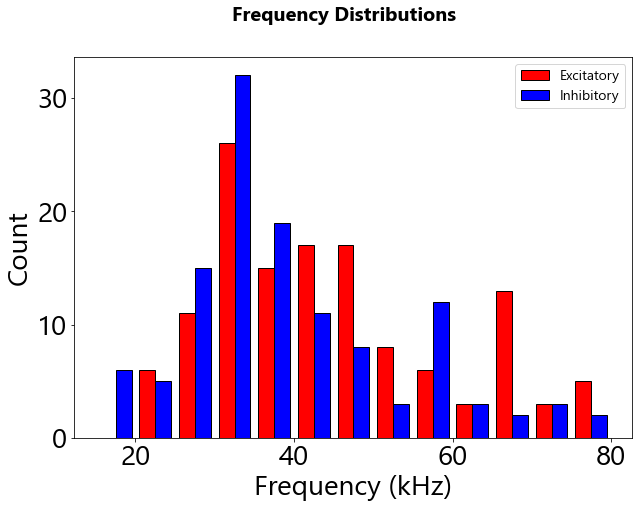

In [83]:
_, ax = plt.subplots(figsize=(10,7))
ax.hist([strf_summary['PeakExcitatoryFrequency'], strf_summary['PeakInhibitoryFrequency']], bins=np.arange(15, 85, 5), edgecolor='k', linewidth=1, ls='solid', color=['red', 'blue'],\
        label=['Excitatory', 'Inhibitory'])
ax.legend(fontsize=14)
ax.set_ylabel('Count')
ax.set_xlabel('Frequency (kHz)')
plt.suptitle('Frequency Distributions')
#plt.savefig('U:/Figures/Thesis/Total Frequency Distributions.png', dpi=300, bbox_inches='tight', facecolor='w')

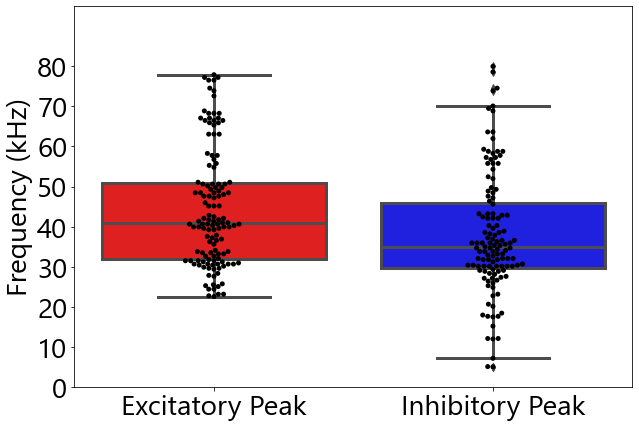

In [84]:
_, ax = plt.subplots(figsize=(10,7))
custom_colors = {'PeakExcitatoryFrequency': 'r', 'PeakInhibitoryFrequency': 'b'}
sns.boxplot(x='variable', y='value', data=strf_summary[['PeakExcitatoryFrequency', 'PeakInhibitoryFrequency']].melt(), ax=ax, palette=custom_colors)
sns.swarmplot(x='variable', y='value', data=strf_summary[['PeakExcitatoryFrequency', 'PeakInhibitoryFrequency']].melt(), ax=ax, color='k').set(xlabel='', xticklabels=['Excitatory Peak', 'Inhibitory Peak'])
ax.set_ylabel('Frequency (kHz)')
ax.set_ylim([0, 95])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.rcParams['font.size'] = '18'
plt.rcParams['font.family'] = 'Segoe UI'
#plt.savefig('U:/Figures/Thesis/EvsI Frequency.png', dpi=300, bbox_inches='tight', facecolor='w')

In [85]:
ranksums(strf_summary.PeakExcitatoryFrequency, strf_summary.PeakInhibitoryFrequency, alternative='greater', nan_policy='omit')

RanksumsResult(statistic=3.3795499314990813, pvalue=0.0003630230883889026)

# Analysis of Peak Latency #

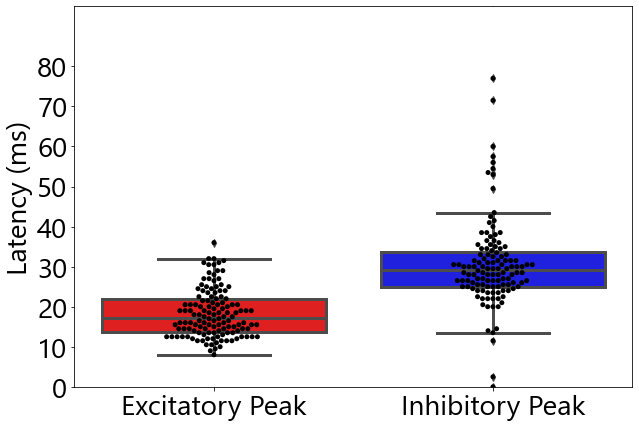

In [86]:
_, ax = plt.subplots(figsize=(10,7))
custom_colors = {'LatencyAtPeak': 'r', 'LatencyAtMin': 'b'}
sns.boxplot(x='variable', y='value', data=strf_summary[['LatencyAtPeak', 'LatencyAtMin']].melt(), palette=custom_colors, ax=ax)
sns.swarmplot(x='variable', y='value', data=strf_summary[['LatencyAtPeak', 'LatencyAtMin']].melt(), color='k', ax=ax).set(xlabel='', ylabel='Latency (ms)', \
                                                                                                                       xticklabels=['Excitatory Peak', 'Inhibitory Peak'])
plt.rcParams['font.size'] = '18'
plt.rcParams['font.family'] = 'Segoe UI'
ax.set_ylim([0, 95])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80]);
#plt.savefig('U:/Figures/Thesis/EvsI Latency.png', dpi=300, bbox_inches='tight', facecolor='w')

In [87]:
parameter = 'LatencyAtPeak'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  0.00205737849836989


In [88]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.060760,0.004282,0.012026
Multi,0.060760,1.000000,0.375968,0.329369
Single,0.004282,0.375968,1.000000,0.470513
Stack,0.012026,0.329369,0.470513,1.000000


Text(2.5, 56.0, '*')

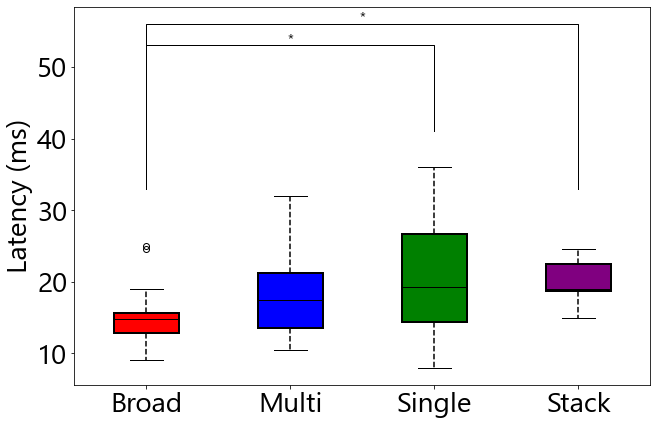

In [89]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.suptitle('');
plt.title('')
plt.ylabel('Latency (ms)');

x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max() + 2, 15, 'k'
plt.plot([x0, x0, x2, x2], [y1-5, y1+h1, y1+h1, y1+3], lw=1, c=color)
plt.text((x0+x2)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = strf_summary[parameter].max() + 5, 15
plt.plot([x0, x0, x3, x3], [y2-5, y2+h2, y2+h2, y2-8], lw=1, c=color)
plt.text((x0+x3)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14)
#plt.savefig('U:/Figures/Thesis/Latency by Type.png', dpi=300, bbox_inches='tight', facecolor='w')

In [90]:
ranksums(strf_summary.LatencyAtPeak, strf_summary.LatencyAtMin, alternative='less', nan_policy='omit')

RanksumsResult(statistic=-10.38225081336123, pvalue=1.4932483395045493e-25)

Text(0.5, 0.98, 'Excitatory Latency Histograms')

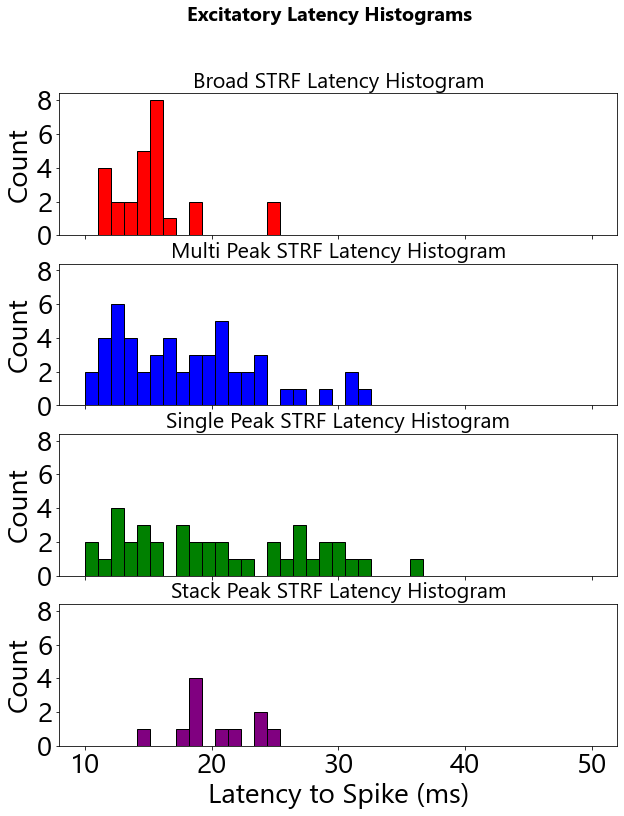

In [91]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True, sharey=True)
axs[0] = strf_summary.query('Type == "Broad"').LatencyAtPeak.plot(ax=axs[0], kind='hist', bins=np.linspace(10, 50, 40),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[0])
axs[0].set_title('Broad STRF Latency Histogram')


axs[1] = strf_summary.query('Type == "Multi"').LatencyAtPeak.plot(ax=axs[1], kind='hist', bins=np.linspace(10, 50, 40),\
                                                                           backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[1])
axs[1].set_title('Multi Peak STRF Latency Histogram')


axs[2] = strf_summary.query('Type == "Single"').LatencyAtPeak.plot(ax=axs[2], kind='hist', bins=np.linspace(10, 50, 40),\
                                                                             backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                            facecolor=color_list[2])
axs[2].set_title('Single Peak STRF Latency Histogram')


axs[3] = strf_summary.query('Type == "Stack"').LatencyAtPeak.plot(ax=axs[3], kind='hist', bins=np.linspace(10, 50, 40),\
                                                                            backend='matplotlib', edgecolor='black', linewidth=1,\
                                                                           facecolor=color_list[3])
axs[3].set_title('Stack Peak STRF Latency Histogram')

for ax in axs.flat:
    ax.set(xlabel='Latency to Spike (ms)', ylabel='Count', yticks=[0, 2, 4, 6, 8])
    ax.label_outer()
plt.suptitle('Excitatory Latency Histograms')
#plt.savefig('U:/Figures/Thesis/Latency Hist.png', dpi=300, bbox_inches='tight', facecolor='w')

Text(0.5, 0.98, 'Latency Distributions')

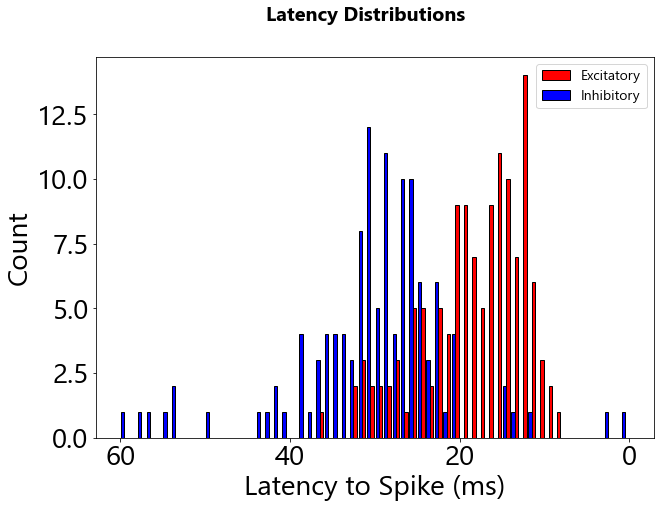

In [92]:
_, ax = plt.subplots(figsize=(10,7))
ax.hist([strf_summary['LatencyAtPeak'], strf_summary['LatencyAtMin']], bins=np.arange(0, 61, 1), edgecolor='k', linewidth=1, ls='solid', color=['red', 'blue'],\
        label=['Excitatory', 'Inhibitory'])
ax.legend(fontsize=14)
ax.invert_xaxis()
ax.set_ylabel('Count')
ax.set_xlabel('Latency to Spike (ms)')
plt.suptitle('Latency Distributions')
#plt.savefig('U:/Figures/Thesis/Total Latency Distributions.png', dpi=300, bbox_inches='tight', facecolor='w')

## IER By Type ##

In [93]:
parameter = 'IER'
f_val, p_val = kruskal(strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter])
print('P-value = ', str(p_val))

P-value =  1.4569844900146768e-05


In [94]:
posthoc_test = sp.posthoc_dunn([strf_summary.query('Type == "Broad"')[parameter], strf_summary.query('Type == "Multi"')[parameter],\
                       strf_summary.query('Type == "Single"')[parameter], strf_summary.query('Type == "Stack"')[parameter]], p_adjust='holm-sidak')
posthoc_test.columns = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test.index = ['Broad', 'Multi', 'Single', 'Stack']
posthoc_test

,Broad,Multi,Single,Stack
Broad,1.000000,0.029958,0.000005,0.029958
Multi,0.029958,1.000000,0.029958,0.540031
Single,0.000005,0.029958,1.000000,0.540031
Stack,0.029958,0.540031,0.540031,1.000000


Text(2.5, 1.3046438067511268, '*')

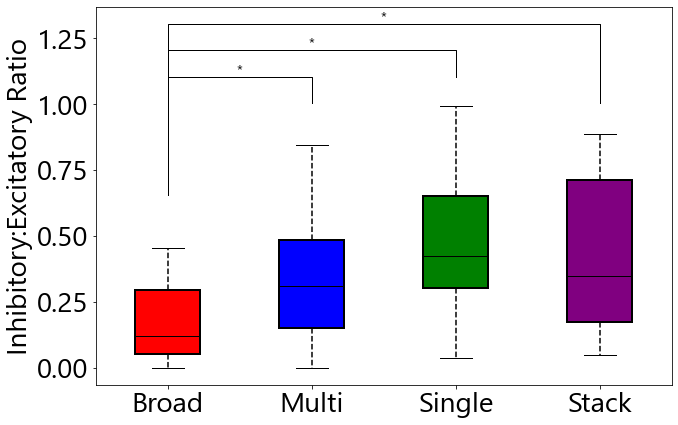

In [95]:
ax = strf_summary.boxplot(column=parameter, by='Type', backend='matplotlib', figsize=(10,7), patch_artist=True,\
                         boxprops=dict(linewidth=2), whiskerprops=dict(linestyle='--', linewidth=1.5), color={'medians': 'black'})
ax.set_xlabel('')
for n in range(0,len(color_list)):
    ax.findobj(mpl.patches.Patch)[n].set_facecolor(color_list[n])
plt.grid(None)
plt.suptitle('');
plt.title('')
plt.ylabel('Inhibitory:Excitatory Ratio');
x0, x1, x2, x3 = 1, 2, 3, 4
y1, h1, color = strf_summary[parameter].max() + 0.01, 0.1, 'k'
plt.plot([x0, x0, x1, x1], [y1-0.35, y1+h1, y1+h1, y1], lw=1, c=color)
plt.text((x0+x1)*0.5, y1+h1, '*', ha='center', va='bottom', color=color, fontsize=14)

y2, h2 = y1 + 0.1, 0.1
plt.plot([x0, x0, x2, x2], [y2, y2+h2, y2+h2, y2], lw=1, c=color)
plt.text((x0+x2)*0.5, y2+h2, '*', ha='center', va='bottom', color=color, fontsize=14)

y3, h3 = y2 + 0.1, 0.1
plt.plot([x0, x0, x3, x3], [y3, y3+h3, y3+h3, y3-0.2], lw=1, c=color)
plt.text((x0+x3)*0.5, y3+h3, '*', ha='center', va='bottom', color=color, fontsize=14)
#plt.savefig('U:/Figures/Thesis/IER By Type.png', dpi=300, bbox_inches='tight', facecolor='w')

0.8095956372679068

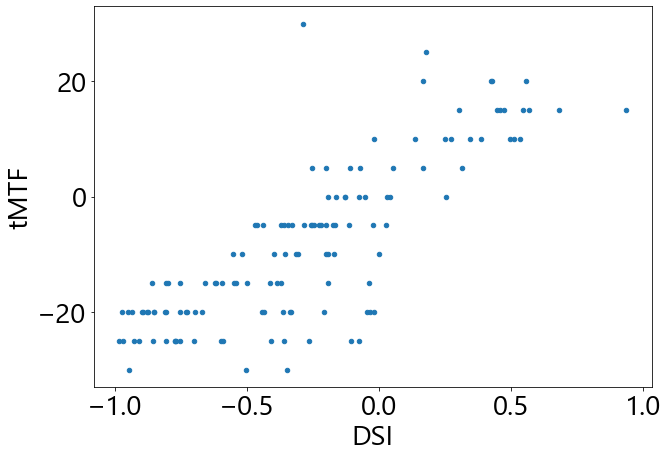

In [96]:
fig, ax = plt.subplots(figsize=(10,7))
strf_summary.plot.scatter(x='DSI', y='tMTF', ax=ax)
strf_summary['DSI'].corr(strf_summary['tMTF'])